In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# On the Docket:

### Stub Strategy (Equal weighted portf)
### Backtesting infrastructure
### Other implementations --> Risk Parity, MV allocation, Weighted MV allocation, mixing previous strategies w/ weights
### Optimization sharpe ratio in levels (window size, strategy, rebalancing rate).

In [32]:
# Fetching Data

data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

np.shape(TEST)

(7800, 6)

## Stub Code

0.010993821121174302


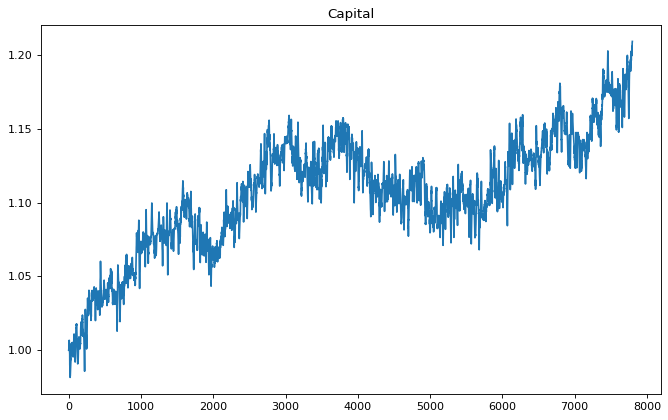

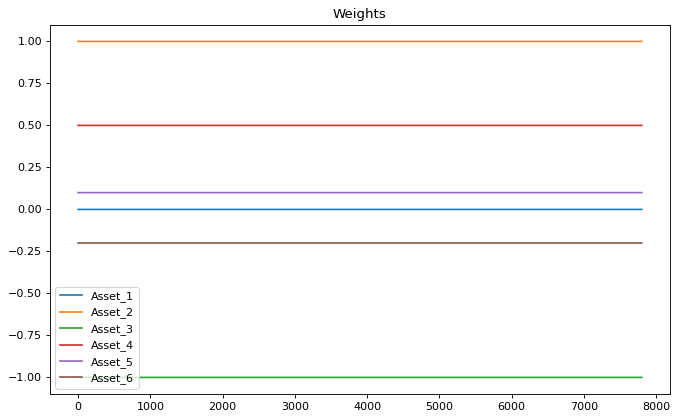

In [68]:
'''
We recommend that you change your train and test split
'''

#TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)


# Change init variables and allocate method in order to change behavior of the allocations.

class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        
        self.running_price_paths = train_data.copy()
        
        self.train_data = train_data.copy()
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

    
        ### TODO Implement your code here
        weights = np.array([0,1,-1,0.5,0.1,-0.2])
        
        return weights


def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()

## Equal Weighted Portfolio

In [34]:
class Equal_Allocator(Allocator):

    def __init__(self, train_data):
        super().__init__(train_data)
        self.excess_returns = self.running_price_paths.pct_change()

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)

    
        ### TODO Implement your code here
        weights = np.ones(6)
        weights = weights / 6
        
        return weights

## Risk-Parity Allocation

### Inverse Vol Matrix --> Fast, somewhat inaccurate, good for daily.

In [35]:
class Inverse_Vol_Alloc(Allocator):
    
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        super().__init__(train_data)
        self.excess_returns = self.running_price_paths.pct_change()
        
        self.lookback_window = 900
        self.current_weights = np.ones(6) / 6

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        new_excess_returns = pd.DataFrame(self.running_price_paths.iloc[-2:].pct_change().dropna())
        self.excess_returns = pd.concat([self.excess_returns, new_excess_returns], ignore_index=True)
    
        ### TODO Implement your code here
        
        cov_matrix = self.excess_returns.iloc[-self.lookback_window:].cov()
        vol = np.sqrt(np.diag(cov_matrix))     # Get standard deviations
        inv_vol = 1 / vol                      # Inverse volatility
        weights = inv_vol / np.sum(inv_vol)   # Normalize

        return weights

### True Risk Parity --> Slow, accurate, good for long-term

Doesn't work lmaoooo

In [36]:
from scipy.optimize import minimize

class Risk_Parity_Alloc(Allocator):
    
    def __init__(self, train_data):
        '''
        Store price history and initialize parameters
        '''
        self.running_price_paths = train_data.copy()

        self.excess_returns = self.running_price_paths.pct_change()
        
        self.train_data = train_data.copy()
        
        self.rebalance_freq = 150    # Rebalance every N ticks
        self.tick_counter = 0
        self.current_weights = np.ones(6) / 6

    def risk_contributions(self, weights, cov_matrix):
        port_var = weights.T @ cov_matrix @ weights
        marginal = cov_matrix @ weights
        total_contrib = weights * marginal
        return total_contrib / np.sqrt(port_var)
    
    def risk_parity_objective(self, weights, cov_matrix):
        rc = self.risk_contributions(weights, cov_matrix)
        target = np.mean(rc)
        return np.sum((rc - target)**2)

    def risk_parity_weights(self, cov_matrix):
        n = cov_matrix.shape[0]
        x0 = np.array([1/n]*n)
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1)] * n  # long-only; change to (-1, 1) for leverage
        
        result = minimize(self.risk_parity_objective, x0, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
        
        return result.x if result.success else x0


    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
    
        ### TODO Implement your code here

        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        new_excess_returns = pd.DataFrame(self.running_price_paths.iloc[-2:].pct_change().dropna())
        self.excess_returns = pd.concat([self.excess_returns, new_excess_returns], ignore_index=True)
        
        if self.tick_counter % self.rebalance_freq != 0:
            self.tick_counter += 1
            return self.current_weights

        cov_matrix = self.excess_returns.cov()

        self.current_weights = self.risk_parity_weights(cov_matrix)

        self.tick_counter += 1

        return self.current_weights


## Mean Variance Allocation

In [129]:
class MV_Alloc():
    def __init__(self, train_data, rebalance_freq, window):
        '''
        Store price history and initialize parameters
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.lookback_window = window  # Number of ticks for rolling returns
        self.rebalance_freq = rebalance_freq    # Rebalance every N ticks
        self.tick_counter = 0
        
        # Initialize weights to equal weights
        self.current_weights = np.array([1/6] * 6)
        
        # Parameters for mean-variance optimization

    def calculate_rolling_er(self, prices, window):
        '''
        Calculate compounded rolling returns over specified window
        '''
        returns = prices.pct_change()
        rolling_rets = (1 + returns).rolling(window).apply(np.prod, raw=True) - 1
        excess_returns = rolling_rets.sub(rolling_rets.mean(axis=1), axis=0).dropna()
        
        return excess_returns
    
    def tangency_portfolio(self, mean_returns, cov_matrix):
        '''
        Compute tangency portfolio weights
        '''
        inverted_cov = np.linalg.pinv(cov_matrix) if np.isclose(np.linalg.det(cov_matrix), 0) else np.linalg.inv(cov_matrix)
        one_vector = np.ones(mean_returns.shape)
        return (inverted_cov @ mean_returns) / (one_vector @ inverted_cov @ mean_returns)
    
    def allocate_portfolio(self, asset_prices):
        self.tick_counter += 1

        # Add new prices directly to NumPy array instead of DataFrame for speed
        if isinstance(self.running_price_paths, pd.DataFrame):
            new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
            self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        else:
            self.running_price_paths = np.vstack([self.running_price_paths, asset_prices])

        # Only rebalance every N ticks
        if self.tick_counter % self.rebalance_freq != 0:
            return self.current_weights

        # Use only most recent window of data
        window = min(self.lookback_window, len(self.running_price_paths))
        prices = self.running_price_paths[-window:]

        # Compute returns (NumPy for speed)
        returns = np.diff(prices, axis=0) / prices[:-1]
        if returns.shape[0] < 2:
            return self.current_weights

        # Expected returns & covariance
        # Rolling momentum (simple mean return over recent window)
        momentum = np.mean(returns[-60:], axis=0)

        # Risk-adjusted expected return
        vol = np.std(returns[-60:], axis=0)
        mu = momentum / (vol + 1e-6)  # Add epsilon to avoid division by zero

        cov = np.cov(returns.T)

        # Tangency portfolio
        try:
            allocation = self.tangency_portfolio(mu, cov)

            # Target return scaling (optional)
            expected_return = mu @ allocation
            allocation *= 0.2 / expected_return

            # Constraint to max leverage of 1
            max_leverage = 1.0 / np.max(np.abs(allocation))
            allocation *= max_leverage

            self.current_weights = allocation
        except Exception as e:
            print("Tangency portfolio failed:", e)
            self.current_weights = np.ones(6) / 6

        return self.current_weights

## Testing Section

In [134]:
# Backtesting Code

data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

def grading_1(train_data, test_data, rebalance_freq, window): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = MV_Alloc(train_data, 150, 900)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

#sharpe, capital, weights = grading_1(TRAIN, TEST, 150, 900)
#Sharpe gets printed to command line
#print(sharpe)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.title("Capital")
# plt.plot(np.arange(len(TEST)), capital)
# plt.show()

# plt.figure(figsize=(10, 6), dpi=80)
# plt.title("Weights")
# plt.plot(np.arange(len(TEST)), weights)
# plt.legend(TEST.columns)
# plt.show()

In [138]:
import math
# sharpe_results_df = pd.DataFrame(sharpe_results)
# capital_results_df = pd.DataFrame(capital_results)
# weights_resuts_df = pd.DataFrame(weights_resuts)

# capital_results_df

sharpe_results_df = pd.read_csv("Case_2_Results\sharpe_results.csv")
capital_results_df = pd.read_csv("Case_2_Results\capital_results.csv")
weights_resuts_df = pd.read_csv("Case_2_Results\weights_results.csv")

adjusted_sharpe = sharpe_results_df
adjusted_sharpe['sharpe'] = adjusted_sharpe['sharpe'] * math.sqrt(7800)
adjusted_sharpe['sharpe'].max()

np.float64(2.333276205444469)

In [194]:
capital_results_df['capital'].max()

np.float64(1.0499996366532796)

## Help Notes

- Apply basic options and math
- Data is machine generated --> can use signal generation and machine learning easily for high sharpe ratios.


# New Strategy: Machine learning with Scikit learn and scipy

- Identify good vs. noisy assets
- Engineer features and forecast returns
- Plug predictions into MV or RP optimization
- Constrain + stabilize weights
- Maximize out-of-sample Sharpe

In [163]:
data = pd.read_csv('Case2.csv')
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

## 1- Identify good vs. noisy assets

In [164]:
returns = TRAIN.pct_change().dropna()

rolling_mean = returns.rolling(window=1000).mean()
rolling_std = returns.rolling(window=1000).std()
rolling_sharpe = rolling_mean / (rolling_std + 1e-6)

avg_sharpe = rolling_sharpe.mean()

avg_sharpe

Asset_1    0.000822
Asset_2   -0.001084
Asset_3    0.000949
Asset_4    0.004935
Asset_5    0.004272
Asset_6    0.004291
dtype: float64

In [165]:
sharpe_vol = rolling_sharpe.std()

sharpe_vol

Asset_1    0.021285
Asset_2    0.018189
Asset_3    0.019646
Asset_4    0.011226
Asset_5    0.010510
Asset_6    0.010484
dtype: float64

In [166]:
autocorr = returns.apply(lambda x: x.autocorr(lag=1))

autocorr

Asset_1   -0.386945
Asset_2   -0.377743
Asset_3   -0.379206
Asset_4    0.644870
Asset_5    0.652661
Asset_6    0.648884
dtype: float64

In [167]:
score = avg_sharpe / (sharpe_vol + 1e-6)
score = 0.7 * (avg_sharpe / (sharpe_vol + 1e-6)) + 0.3 * autocorr
ranked_assets = score.sort_values(ascending=False)
ranked_assets

Asset_4    0.501188
Asset_6    0.481152
Asset_5    0.480293
Asset_3   -0.079956
Asset_1   -0.089063
Asset_2   -0.155043
dtype: float64

## 2 - Engineer features and forecast returns

In [192]:
returns = returns[['Asset_4', 'Asset_5', 'Asset_6']]

lags = [1, 5, 10]
for col in returns.columns:
    for lag in lags:
        returns[f'{col}_lag_{lag}'] = returns[col].shift(lag)

returns.dropna()

,Asset_4,Asset_5,Asset_6,Asset_4_lag_1,Asset_4_lag_5,Asset_4_lag_10,Asset_5_lag_1,Asset_5_lag_5,Asset_5_lag_10,Asset_6_lag_1,Asset_6_lag_5,Asset_6_lag_10
11,0.005068,0.000305,-0.000465,0.001432,0.000337,0.001425,0.002856,0.000141,-0.000351,0.000303,0.001832,0.001650
12,0.000698,0.002467,0.002317,0.005068,0.003796,0.001048,0.000305,0.001434,-0.000341,-0.000465,0.000624,-0.000098
13,0.002907,-0.000038,-0.003620,0.000698,0.000504,0.004954,0.002467,0.001865,0.002361,0.002317,-0.004049,0.000755
14,0.004170,0.001360,0.001838,0.002907,0.000997,-0.000328,-0.000038,-0.002724,0.000271,-0.003620,0.005928,-0.003258
15,0.001137,-0.001649,-0.000384,0.004170,0.001432,0.002962,0.001360,0.002856,-0.000282,0.001838,0.000303,0.000238
...,...,...,...,...,...,...,...,...,...,...,...,...
31195,0.001113,-0.002995,0.000467,0.000506,-0.001275,-0.001868,-0.002718,0.003552,0.003283,0.001899,0.004083,0.002905
31196,0.001346,-0.002819,-0.001513,0.001113,0.000694,-0.001744,-0.002995,-0.003639,0.003514,0.000467,-0.000780,0.000567
31197,0.001044,-0.003597,0.002214,0.001346,0.003245,-0.003157,-0.002819,-0.003159,0.002547,-0.001513,-0.001447,0.002791
31198,0.003568,-0.002306,0.000693,0.001044,0.001152,0.000275,-0.003597,-0.001603,0.003021,0.002214,0.000958,0.003344


In [177]:
window = 30
rolling_mean = returns.rolling(window).mean()
rolling_std = returns.rolling(window).std()
z_scores = (returns - rolling_mean) / (rolling_std + 1e-6)

correlation_matrix = returns.corr()

correlation_matrix

,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_1_lag_1,Asset_1_lag_5,Asset_1_lag_10,Asset_2_lag_1,...,Asset_3_lag_10,Asset_4_lag_1,Asset_4_lag_5,Asset_4_lag_10,Asset_5_lag_1,Asset_5_lag_5,Asset_5_lag_10,Asset_6_lag_1,Asset_6_lag_5,Asset_6_lag_10
Asset_1,1.000000,0.124513,0.086791,0.001001,0.003361,-0.004809,-0.386945,-0.023062,0.001152,0.010341,...,-0.010244,-0.000407,-0.005691,-0.002317,-0.005357,-0.002946,-0.005369,-0.007312,-0.004438,-0.005890
Asset_2,0.124513,1.000000,0.118073,-0.002332,-0.001456,-0.002396,0.003955,0.000125,0.006883,-0.377743,...,-0.000963,-0.004089,-0.002158,-0.004888,-0.002772,-0.003414,-0.006643,-0.004615,-0.012876,-0.001173
Asset_3,0.086791,0.118073,1.000000,-0.002366,-0.011942,0.000418,0.006902,0.001411,0.002737,-0.005916,...,-0.019585,-0.000546,-0.004346,0.002837,-0.000930,0.001492,0.003272,-0.001933,-0.001735,-0.003855
Asset_4,0.001001,-0.002332,-0.002366,1.000000,-0.002061,0.006079,-0.002886,-0.002311,-0.002398,-0.005565,...,-0.006675,0.644870,0.210949,-0.416144,0.001412,-0.001037,-0.005396,0.002635,-0.002140,-0.007950
Asset_5,0.003361,-0.001456,-0.011942,-0.002061,1.000000,0.002843,-0.003622,-0.002618,-0.004048,-0.002778,...,0.000780,0.001653,-0.000859,-0.000028,0.652661,0.214050,-0.426098,-0.000416,0.001773,0.010744
Asset_6,-0.004809,-0.002396,0.000418,0.006079,0.002843,1.000000,0.003076,-0.006609,-0.000999,-0.002980,...,-0.000733,0.006761,0.008670,0.007952,-0.001688,0.001385,-0.007294,0.648884,0.214208,-0.421616
Asset_1_lag_1,-0.386945,0.003955,0.006902,-0.002886,-0.003622,0.003076,1.000000,0.017059,-0.000223,0.124514,...,0.003914,0.001005,0.002210,-0.001098,0.003350,0.002523,0.001913,-0.004810,-0.004845,-0.004858
Asset_1_lag_5,-0.023062,0.000125,0.001411,-0.002311,-0.002618,-0.006609,0.017059,1.000000,-0.023137,-0.002411,...,-0.000968,0.006595,0.001032,-0.005672,-0.005703,0.003351,-0.003025,0.006252,-0.004831,-0.004470
Asset_1_lag_10,0.001152,0.006883,0.002737,-0.002398,-0.004048,-0.000999,-0.000223,-0.023137,1.000000,-0.001453,...,0.086768,-0.000242,-0.002322,0.001063,-0.002631,-0.002599,0.003265,0.001859,-0.006620,-0.004903
Asset_2_lag_1,0.010341,-0.377743,-0.005916,-0.005565,-0.002778,-0.002980,0.124514,-0.002411,-0.001453,1.000000,...,0.002211,-0.002332,-0.003711,-0.001050,-0.001456,-0.000906,-0.001512,-0.002396,0.001494,-0.001613


In [179]:
mu = returns.rolling(window=20).mean().iloc[-1]
sharpe_signal = returns.rolling(60).mean() / (returns.rolling(60).std() + 1e-6)
mu = sharpe_signal.iloc[-1]


In [183]:
from sklearn.linear_model import Ridge

# Predict next tick's return using lagged features
X = returns.dropna()
y = returns.shift(-1).dropna()

model = Ridge(alpha=0.1).fit(X, y)
mu = model.predict(X.iloc[[-1]])[0]  # Latest features

mu

array([-4.31987649e-05,  1.04043450e-05,  6.73794819e-05,  1.60431329e-03,
       -2.97165154e-03, -4.62054423e-05, -3.55211712e-04, -1.07140663e-04,
       -5.63605042e-04, -2.29404401e-04,  6.25120821e-05, -1.04814230e-04,
       -2.98514823e-04,  1.56599946e-04,  1.76963457e-04,  2.80626715e-03,
        4.75884268e-04, -2.33106116e-03, -2.33255646e-03, -2.15190937e-03,
        2.06880584e-03,  5.53963731e-04,  1.48427985e-03,  4.93541102e-04])